In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob
import shutil

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [ ]:
TRAIN_PATH = Path('../data/CarlaTrain')
CARLA_1_PATH = Path('../data/Carla1')
CARLA_2_PATH = Path('../data/Carla2')
CARLA_3_PATH = Path('../data/Carla3')
CARLA_4_PATH = Path('../data/Carla4')
CARLA_5_PATH = Path('../data/Carla5')
ALL_PATH = Path('../data/all')

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

In [ ]:
(ALL_PATH/TRAIN_DN).mkdir(exist_ok=True)
(ALL_PATH/MASKS_DN).mkdir(exist_ok=True)

In [ ]:
len(glob(str(ALL_PATH/TRAIN_DN/'*.png'))), len(glob(str(ALL_PATH/MASKS_DN/'*.png')))

### C1, Train

In [ ]:
c_names = glob(str(CARLA_1_PATH/'*/*/*.png'))
for f in c_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    skip = int(fn[-5])%4 != 0
    if skip: continue
    targ_path = ALL_PATH/f_pt[4]/('c1_'+f_pt[3]+'_'+f_pt[-1])
    shutil.copy2(f, str(targ_path))

In [ ]:
t_names = glob(str(TRAIN_PATH/TRAIN_DN/'*.png')) + glob(str(TRAIN_PATH/MASKS_DN/'*.png'))
for f in t_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    skip = int(fn[-5])%2 != 0
    if skip: continue
    targ_path = ALL_PATH/f_pt[3]/(f_pt[2]+'_'+f_pt[-1])
    shutil.copy2(f, str(targ_path))

### Carla 2

In [ ]:
c_names = glob(str(CARLA_2_PATH/'*/*/*.png'))
for f in c_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    skip = int(fn[-5])%4 != 0
    if skip: continue
    targ_path = ALL_PATH/f_pt[4]/('c2_'+f_pt[3]+'_'+f_pt[-1])
#     print(targ_path)
    shutil.copy2(f, str(targ_path))

### Carla 3

In [ ]:
c3_names = glob(str(CARLA_3_PATH/TRAIN_DN/'*.png')) + glob(str(CARLA_3_PATH/MASKS_DN/'*.png'))
for f in c3_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    targ_path = ALL_PATH/f_pt[3]/f_pt[-1]
    skip = int(fn[-5])%4 != 0
    if skip: continue
#     print(targ_path)
    shutil.copy2(f, str(targ_path))

### Carla 4, 5

In [ ]:
c_names = glob(str(CARLA_4_PATH/'*/*/*.png'))
for f in c_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    skip = int(fn[-5])%4 != 0
    if skip: continue
    targ_path = ALL_PATH/f_pt[4]/('c4_'+f_pt[3]+'_'+f_pt[-1])
#     print(targ_path)
    shutil.copy2(f, str(targ_path))

In [ ]:
c_names = glob(str(CARLA_4_PATH/'*/*/*.png'))
for f in c_names:
    f_pt = Path(f).parts
    fn = f_pt[-1]
    skip = int(fn[-5])%4 != 0
    if skip: continue
    targ_path = ALL_PATH/f_pt[4]/('c5_'+f_pt[3]+'_'+f_pt[-1])
#     print(targ_path)
    shutil.copy2(f, str(targ_path))

In [ ]:
len(glob(str(ALL_PATH/(TRAIN_DN)/'*.png'))), len(glob(str(ALL_PATH/MASKS_DN/'*.png')))

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

### Resize images

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz = 300
ratio = 4/3

In [ ]:
(ALL_PATH/f'{MASKS_DN}-{sz}').mkdir(exist_ok=True)

In [ ]:
def resize_mask(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{MASKS_DN}-{sz}'/fn.name)

files = list((ALL_PATH/MASKS_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [ ]:
(ALL_PATH/f'{TRAIN_DN}-{sz}').mkdir(exist_ok=True)

In [ ]:
def resize_img(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{TRAIN_DN}-{sz}'/fn.name)

files = list((ALL_PATH/TRAIN_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [ ]:
len(glob(str(ALL_PATH/(TRAIN_DN+'-150')/'*.png'))), len(glob(str(ALL_PATH/(MASKS_DN+'-300')/'*.png')))

### Create Prediction images from Test Data

In [10]:
TEST_PATH = Path('../data/TestData')
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

In [ ]:
pths = glob(str(ALL_PATH/(TRAIN_DN)/'*.png'))

In [ ]:
pth = pths[0]

In [ ]:
plt.imread(str(pth)).shape

In [ ]:
plt.imshow(plt.imread(str(pth)))

In [1]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO
from pathlib import Path
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, vgg11_bn
torch.backends.cudnn.benchmark=True

# ## Models
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))
    
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

def cut_model(m, cut):
    return list(m.children())[:cut] if cut else [m]

def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6]
}


class FP16(nn.Module):
    def __init__(self, module): 
        super(FP16, self).__init__()
        self.module = batchnorm_to_fp32(module.half())
        
    def forward(self, input): 
        return self.module(input.half())
    
    def load_state_dict(self, *inputs, **kwargs):
        self.module.load_state_dict(*inputs, **kwargs)

    def state_dict(self, *inputs, **kwargs):
        return self.module.state_dict(*inputs, **kwargs)
    
def batchnorm_to_fp32(module):
    '''
    BatchNorm layers to have parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        batchnorm_to_fp32(child)
    return module

# Load model
m = Unet34()

In [2]:
cuda_enabled = torch.cuda.is_available()
model_path = str('../data/all/models/600urn-19-weights-26-r7.h5')
if cuda_enabled:
    m = FP16(m).cuda().half()
    m.load_state_dict(torch.load(model_path))
else:
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))


# Process video
# file = sys.argv[-1]
file = '../data/outputvideo.mp4'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

imagenet_stats = torch.cuda.FloatTensor([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    if x.mean() > 1:
        x.div_(255.0)
    m,s = imagenet_stats
    x.sub_(m.view(-1, 1, 1))
    x.div_(s.view(-1, 1, 1))
    return x

def crop_bg(x):
    # Original
    h = x.shape[2]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,:,top:bot,:]

def pad(x):
    # Original
    b,c,w,h = x.shape
    if h%32 == 0:
        return x, 0
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = np.rollaxis(video, 3, 1)
    f1 = torch.from_numpy(f1).float().cuda()
    f1 = crop_bg(f1)
    f1 = normalize(f1)
    return f1.contiguous()

video_p = preprocess(video)
answer_key = {}
bs = 8

import gc
gc.collect()

0

In [3]:
video.shape

(1000, 600, 800, 3)

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [9]:
import scipy

In [ ]:
for i in range(0,video_p.shape[0],bs):
    x = video_p[i:i+bs]
    
    x,p = pad(x)
    preds = m(torch.autograd.Variable(x))
    mx,idx = torch.max(preds, 1)
    
    if p > 0:
        idx = idx[:,:,:-p]
    idx = F.pad(idx, (0,0,160,56), "constant", 0)
    
    # Frame numbering starts at 1
    frame_idx = i
    for frame in idx:
        # Look for red cars :)
        frame = frame.data.cpu().numpy()
        
        video_f = video[frame_idx]
        res = np.zeros_like(video_f, dtype=int)
        res[(frame==1)] = VEHICLES
        res[(frame==2)] = ROADS
        
#         binary_car_result = (frame==1).astype('uint8')

        # Look for road :)
#         binary_road_result = (frame==2).astype('uint8')

#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
        
        scipy.misc.imsave(TEST_PATH/MASKS_DN/f'{frame_idx}.png', res)
        scipy.misc.imsave(TEST_PATH/TRAIN_DN/f'{frame_idx}.png', video_f)

        # Increment frame
        frame_idx+=1
        

# Print output in proper json format
# print (json.dumps(answer_key))

# rlist = []
# for frame in range(1,len(ans_data.keys())+1):
#     res = np.zeros_like(video[frame])
#     c = decode(ans_data[str(frame)][0])
#     r = decode(ans_data[str(frame)][1])
#     res[c==True] = VEHICLES
#     res[r==True] = ROADS
#     rlist.append(res)
#     scipy.misc.imsave(DATA_PATH/f'AnswersSeg/{frame-1}.png', res)
#     scipy.misc.imsave(DATA_PATH/f'AnswersRGB/{frame-1}.png', video[frame])

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [7]:
import matplotlib.pyplot as plt

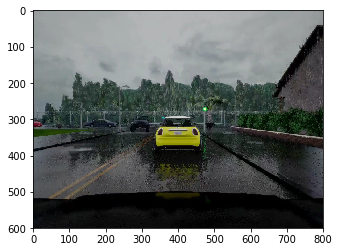

In [11]:
plt.imshow(plt.imread(str(TEST_PATH/TRAIN_DN/'0.png')))

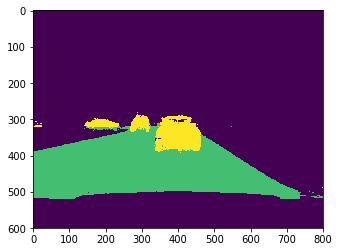

In [13]:
plt.imshow(plt.imread(str(TEST_PATH/MASKS_DN/'0.png'))[:,:,0])

### Resize Test data

In [19]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz = 150
ratio = 4/3

In [20]:
(TEST_PATH/f'{MASKS_DN}-{sz}').mkdir(exist_ok=True)

In [21]:
def resize_mask(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{MASKS_DN}-{sz}'/fn.name)

files = list((TEST_PATH/MASKS_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [22]:
(TEST_PATH/f'{TRAIN_DN}-{sz}').mkdir(exist_ok=True)

In [23]:
def resize_img(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{TRAIN_DN}-{sz}'/fn.name)

files = list((TEST_PATH/TRAIN_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [24]:
len(glob(str(TEST_PATH/(TRAIN_DN+'-150')/'*.png'))), len(glob(str(TEST_PATH/(MASKS_DN+'-300')/'*.png')))

(1000, 1000)